In [ ]:
# ============================================================
# AI Agent Playing Doom with Trained CNN Model
# ============================================================

import vizdoom as vzd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import os
import tensorflow as tf
from tensorflow import keras

# Image dimensions (must match training)
IMG_HEIGHT = 160
IMG_WIDTH = 120

print(f"TensorFlow version: {tf.__version__}")

# Load the trained model
print("Loading trained model...")
model = keras.models.load_model('best_model.keras')
print("✓ Model loaded successfully!")

def preprocess_frame_for_model(screen_buffer, target_height=IMG_HEIGHT, target_width=IMG_WIDTH):
    """
    Preprocess VizDoom screen buffer to match training preprocessing.
    
    Args:
        screen_buffer: Raw screen buffer from VizDoom (C, H, W) format
        target_height: Target height (should match training: 160)
        target_width: Target width (should match training: 120)
    
    Returns:
        Preprocessed frame ready for model input
    """
    # Convert from (C, H, W) to (H, W, C) if needed
    if len(screen_buffer.shape) == 3 and screen_buffer.shape[0] == 3:
        screen_buffer = np.transpose(screen_buffer, (1, 2, 0))
    
    # Resize to match training input size
    frame = cv2.resize(screen_buffer, (target_width, target_height))
    
    # Normalize to [0, 1]
    frame = frame.astype(np.float32) / 255.0
    
    return frame

def setup_vizdoom_game(map_name="map01", visible=True):
    """Setup VizDoom game instance (matching training data collection setup)"""
    game = vzd.DoomGame()
    
    # Find scenarios directory
    scenarios_path = os.path.join(os.path.dirname(vzd.__file__), 'scenarios')
    basic_wad_path = os.path.join(scenarios_path, 'basic.wad')
    
    # Set scenario
    game.set_doom_scenario_path(basic_wad_path)
    game.set_doom_map(map_name)
    
    # Configure screen
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    game.set_screen_format(vzd.ScreenFormat.RGB24)
    game.set_render_hud(True)
    game.set_render_crosshair(True)
    game.set_render_weapon(True)
    
    # Add the 3 buttons our model predicts (matching training data)
    game.add_available_button(vzd.Button.MOVE_LEFT)    # Index 0
    game.add_available_button(vzd.Button.MOVE_RIGHT)   # Index 1
    game.add_available_button(vzd.Button.ATTACK)       # Index 2
    
    # Game settings
    game.set_episode_timeout(2000)
    game.set_window_visible(visible)
    game.set_mode(vzd.Mode.PLAYER)
    
    game.init()
    return game

def run_ai_agent(num_episodes=3, max_steps=1000, prediction_threshold=0.5, 
                 visualize=True, show_interval=50):
    """
    Run the trained AI agent in VizDoom.
    
    Args:
        num_episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        prediction_threshold: Threshold for converting predictions to actions (0.5 = 50%)
        visualize: Whether to show live predictions
        show_interval: Update visualization every N frames
    """
    # Initialize game
    game = setup_vizdoom_game(visible=True)
    
    # Statistics tracking
    episode_rewards = []
    episode_lengths = []
    action_counts = {'left': 0, 'right': 0, 'attack': 0, 'no_action': 0}
    
    print(f"\n{'='*60}")
    print("AI AGENT PLAYING DOOM")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes}")
    print(f"Prediction threshold: {prediction_threshold}")
    print(f"Model: {model.name if hasattr(model, 'name') else 'CNN'}")
    print(f"{'='*60}\n")
    
    try:
        for episode in range(num_episodes):
            print(f"\n--- Episode {episode + 1}/{num_episodes} ---")
            game.new_episode()
            
            total_reward = 0
            step = 0
            
            while not game.is_episode_finished() and step < max_steps:
                # Get current state
                state = game.get_state()
                
                if state is None:
                    break
                
                # Preprocess frame
                screen_buffer = state.screen_buffer
                processed_frame = preprocess_frame_for_model(screen_buffer)
                
                # Predict action (add batch dimension)
                predictions = model.predict(
                    processed_frame[np.newaxis, ...], 
                    verbose=0
                )[0]
                
                # Convert predictions to actions
                # predictions = [left_prob, right_prob, attack_prob]
                # Note ignoring prediction threshold for now
                best_action_idx = np.argmax(predictions)
                action = [i == best_action_idx for i in range(len(predictions))]

                # Track action statistics
                if action[0]:
                    action_counts['left'] += 1
                if action[1]:
                    action_counts['right'] += 1
                if action[2]:
                    action_counts['attack'] += 1
                if not any(action):
                    action_counts['no_action'] += 1
                
                # Execute action in game
                reward = game.make_action(action)
                total_reward += reward
                
                # Visualize predictions periodically
                if visualize and step % show_interval == 0:
                    clear_output(wait=True)
                    print(f"Episode {episode + 1}/{num_episodes} | Step {step}/{max_steps}")
                    print(f"Predictions: L={predictions[0]:.3f} R={predictions[1]:.3f} A={predictions[2]:.3f}")
                    print(f"Action: L={action[0]} R={action[1]} A={action[2]}")
                    print(f"Reward (this step): {reward:.1f}")
                    print(f"Total reward: {total_reward:.1f}")
                
                step += 1
                time.sleep(0.01)  # Small delay for visualization
            
            # Episode statistics
            episode_rewards.append(total_reward)
            episode_lengths.append(step)
            
            print(f"Episode {episode + 1} complete!")
            print(f"  Total reward: {total_reward:.1f}")
            print(f"  Steps: {step}")
            print(f"  Avg reward/step: {total_reward/step if step > 0 else 0:.2f}")
    
    finally:
        game.close()
    
    # Print final statistics
    print(f"\n{'='*60}")
    print("AGENT PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    print(f"Episodes completed: {len(episode_rewards)}")
    print(f"Average reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Average episode length: {np.mean(episode_lengths):.1f} steps")
    print(f"\nAction distribution:")
    total_actions = sum(action_counts.values())
    for action_name, count in action_counts.items():
        percentage = (count / total_actions * 100) if total_actions > 0 else 0
        print(f"  {action_name.capitalize():12s}: {count:5d} ({percentage:5.1f}%)")
    
    # Plot results
    if len(episode_rewards) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Rewards plot
        ax1.plot(episode_rewards, marker='o', linewidth=2, markersize=8)
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.set_title('AI Agent Performance')
        ax1.grid(True, alpha=0.3)
        
        # Action distribution
        action_names = list(action_counts.keys())
        action_values = list(action_counts.values())
        ax2.bar(action_names, action_values, color=['#ff6b6b', '#4ecdc4', '#ffe66d', '#95e1d3'])
        ax2.set_xlabel('Action Type')
        ax2.set_ylabel('Count')
        ax2.set_title('Action Distribution')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    return episode_rewards, action_counts



Episode 3/3 | Step 0/1000
Predictions: L=0.204 R=0.318 A=0.159
Action: L=False R=True A=False
Reward (this step): 0.0
Total reward: 0.0
Episode 3 complete!
  Total reward: 101.0
  Steps: 33
  Avg reward/step: 3.06

AGENT PERFORMANCE SUMMARY
Episodes completed: 3
Average reward: 101.00 ± 0.00
Average episode length: 59.3 steps

Action distribution:
  Left        :   103 ( 57.9%)
  Right       :    58 ( 32.6%)
  Attack      :    17 (  9.6%)
  No_action   :     0 (  0.0%)


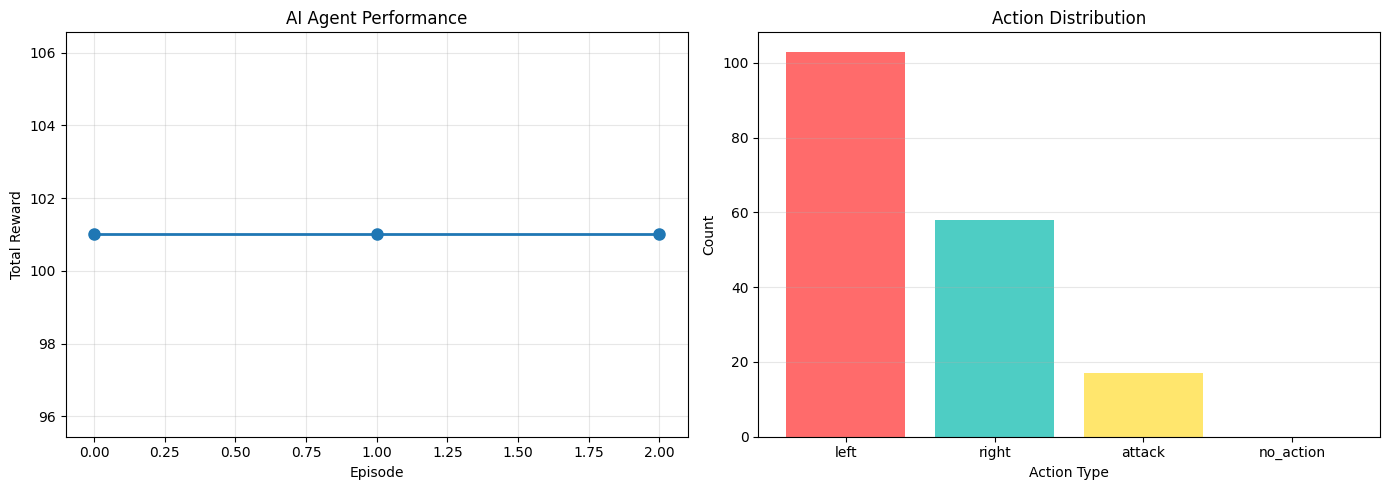

In [4]:
# Run the AI agent
print("Starting AI agent...")
print("Watch the game window to see your CNN model playing!\n")

episode_rewards, action_stats = run_ai_agent(
    num_episodes=3,           # Number of episodes to play
    max_steps=1000,           # Maximum steps per episode
    prediction_threshold=0.5, # Threshold for action activation
    visualize=True,           # Show predictions in notebook
    show_interval=50          # Update display every 50 frames
)